<a href="https://colab.research.google.com/github/ehddnr301/dacon_motion/blob/master/dacon_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2
import glob

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten, Dense
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

In [3]:
TRAIN_IMG_FOLDER = '/content/gdrive/MyDrive/dacon-motion/train_imgs'

TEST_IMG_FOLDER = '/content/gdrive/MyDrive/dacon-motion/test_imgs'

TRAIN_DF = '/content/gdrive/MyDrive/dacon-motion/train_df.csv'
SUB_DF = '/content/gdrive/MyDrive/dacon-motion/sample_submission.csv'

IMAGE_HEIGHT = 540
IMAGE_WIDTH = 960

In [4]:
!unzip -o '/content/gdrive/MyDrive/dacon-motion/train_imgs.zip' -d '/content/gdrive/MyDrive/dacon-motion/train_imgs'
# -o 는 overwrite option 입니다.
# -n 로 설정하면 이미 있는 파일의 경우 덮어쓰지 않습니다.

Archive:  /content/gdrive/MyDrive/dacon-motion/train_imgs.zip
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs/001-1-1-01-Z17_A-0000001.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs/001-1-1-01-Z17_A-0000003.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs/001-1-1-01-Z17_A-0000005.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs/001-1-1-01-Z17_A-0000007.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs/001-1-1-01-Z17_A-0000009.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs/001-1-1-01-Z17_A-0000011.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs/001-1-1-01-Z17_A-0000013.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs/001-1-1-01-Z17_A-0000015.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs/001-1-1-01-Z17_A-0000017.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs/001-1-1-01-Z17_A-0000019.jpg  
  inflating: /cont

In [5]:
!unzip -o '/content/gdrive/MyDrive/dacon-motion/test_imgs.zip' -d '/content/gdrive/MyDrive/dacon-motion/test_imgs'

Archive:  /content/gdrive/MyDrive/dacon-motion/test_imgs.zip
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs/649-2-4-32-Z148_A-0000001.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs/649-2-4-32-Z148_A-0000003.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs/649-2-4-32-Z148_A-0000005.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs/649-2-4-32-Z148_A-0000007.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs/649-2-4-32-Z148_A-0000009.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs/649-2-4-32-Z148_A-0000011.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs/649-2-4-32-Z148_A-0000013.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs/649-2-4-32-Z148_A-0000015.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs/649-2-4-32-Z148_A-0000017.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs/649-2-4-32-Z148_A-0000019.jpg  
  inflating: /conte

In [6]:
train = pd.read_csv(TRAIN_DF)
submission = pd.read_csv(SUB_DF)

In [7]:
train.iloc[:,1:49] = train.iloc[:,1:49] / 2 # 1/2 로 리사이즈 할것이기때문
train.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,523.194815,172.378941,520.827647,164.910113,529.714754,167.242115,510.058898,169.445270,524.000000,171.50000,496.000000,197.000000,527.000000,200.000000,478.000000,184.000000,567.000000,185.500000,501.748621,163.820043,539.000000,170.500000,499.500000,285.000000,523.000000,286.500000,497.500000,347.500000,527.000000,349.000000,491.500000,410.000000,521.00000,414.500000,509.553639,186.883111,506.568680,158.155848,533.500000,167.500000,509.742115,227.500000,513.257885,257.027365,499.289418,413.359006,531.602034,419.413733
1,001-1-1-01-Z17_A-0000003.jpg,534.925340,170.355747,529.304276,162.296845,537.621055,162.796845,520.711498,165.847408,532.796841,166.98423,505.000000,199.000000,538.500000,193.000000,487.000000,199.000000,572.000000,168.500000,502.000000,173.000000,547.000000,163.000000,510.000000,278.500000,534.500000,283.500000,506.500000,291.500000,536.000000,348.500000,501.921891,339.398515,521.00000,414.500000,523.639720,181.015949,508.691556,166.445270,540.593690,161.500000,523.476624,227.031353,529.383116,254.398515,501.132838,349.531353,533.188117,420.749723
2,001-1-1-01-Z17_A-0000005.jpg,542.237951,168.500004,539.358998,161.878945,547.824206,162.621059,530.519942,164.675786,543.230516,167.05473,510.000000,190.500000,541.500000,194.500000,492.000000,181.000000,581.500000,186.000000,513.753709,163.691560,555.500000,170.000000,508.000000,276.000000,530.500000,278.000000,509.000000,337.000000,535.000000,348.000000,493.851575,394.433671,522.00000,413.000000,531.514858,179.339977,521.187388,159.515770,550.500000,167.000000,522.269480,221.027365,526.422072,247.945270,494.718923,404.378945,533.035709,420.874777
3,001-1-1-01-Z17_A-0000007.jpg,521.160023,180.726344,518.953597,172.058902,525.164191,176.956864,508.422072,170.456868,521.082096,179.67579,484.000000,196.000000,505.000000,205.500000,470.906306,169.851575,554.500000,220.500000,485.827465,164.324214,533.406302,191.703155,486.000000,285.500000,500.000000,279.500000,495.500000,350.000000,555.000000,234.500000,495.703151,408.066325,566.50000,295.500000,503.651492,187.089703,490.921164,164.554730,528.703159,186.230520,491.468647,229.054731,495.187562,253.812433,500.652588,414.616884,579.758249,299.694999
4,001-1-1-01-Z17_A-0000009.jpg,529.023197,171.582096,523.358998,165.851581,529.066325,165.890539,515.629403,169.296845,524.906310,169.09369,498.500000,196.500000,527.000000,197.500000,480.500000,211.500000,566.000000,180.000000,494.338152,178.844148,540.000000,168.500000,500.000000,283.500000,521.500000,285.000000,508.500000,336.500000,529.500000,350.500000,499.203151,392.285250,520.00000,413.500000,518.159473,183.097864,499.888710,174.914645,534.824214,167.054730,512.421895,226.843786,517.195544,255.421895,499.312616,402.609461,529.812978,419.882551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190,642-2-4-31-Z148_E-0000023.jpg,318.625526,390.671130,558.567909,185.333651,548.561614,165.321100,547.727769,177.828937,541.682300,162.81951,535.636831,164.695693,532.728114,197.124072,545.461451,225.824948,514.844868,161.702121,486.201410,106.824219,481.676559,96.476993,491.281657,203.570869,476.239661,168.530433,459.780190,108.895399,455.179356,98.101953,493.439892,222.256298,458.11248,

In [8]:
#submission 파일 불러오기
submission.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,649-2-4-32-Z148_A-0000003.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
train_paths = glob.glob(f'{TRAIN_IMG_FOLDER}/*.jpg')
test_paths = glob.glob(f'{TEST_IMG_FOLDER}/*.jpg')
print(len(train_paths), len(test_paths))

4195 1600


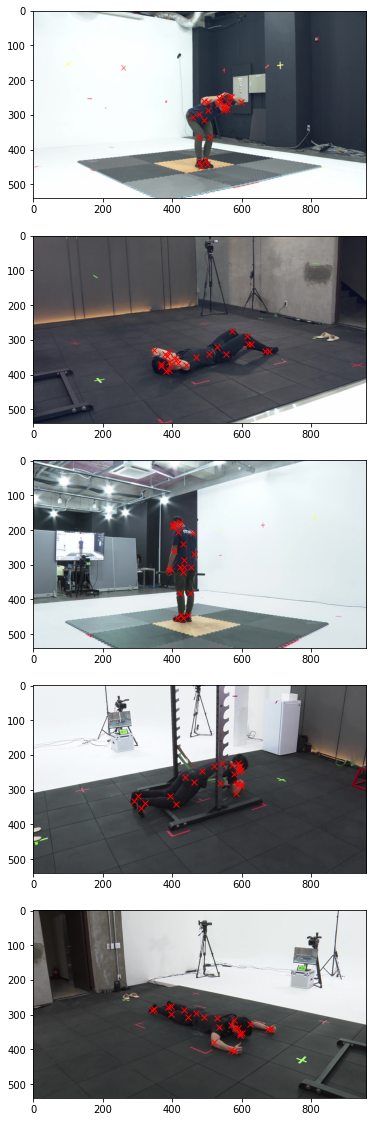

In [10]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img_name = img_sample_path.split('/')[6]
    img = Image.open(img_sample_path)
    img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    img_np = np.array(img)
    key = train[train['image'] == img_name].iloc[0, 1:49]

    keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인

    for j in range(0,len(keypoint.columns),2):
        plt.plot(key[j], key[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1

In [11]:
train['path'] = train_paths

In [12]:
target_list = list(train.columns)[1:49]

In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory=TRAIN_IMG_FOLDER,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    x_col="image",
    y_col=target_list,
    class_mode='raw',
    batch_size=8,
)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    submission,
    directory=TEST_IMG_FOLDER,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    x_col="image",
    y_col=target_list,
    class_mode='raw',
    batch_size=8,
)

Found 4195 validated image filenames.
Found 1600 validated image filenames.


In [14]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [15]:
def create_model():
  model = Sequential()

  model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3)))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())

  model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())

  model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())

  model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))


  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(48))

  model.compile(optimizer='adam', 
                loss='mean_squared_error',
                metrics=['mae'])
  
  return model

In [16]:
motion_model = create_model()

In [17]:
motion_model.fit(train_generator,epochs = 20, verbose=1)

Epoch 1/20
525/525 [==============================] - 154s 283ms/step - loss: 18608.2733 - mae: 99.8218
Epoch 2/20
525/525 [==============================] - 143s 272ms/step - loss: 4192.5294 - mae: 50.4061
Epoch 3/20
525/525 [==============================] - 142s 270ms/step - loss: 2955.3329 - mae: 42.2441
Epoch 4/20
525/525 [==============================] - 143s 271ms/step - loss: 2874.1216 - mae: 41.1516
Epoch 5/20
525/525 [==============================] - 141s 267ms/step - loss: 2859.6299 - mae: 41.4771
Epoch 6/20
525/525 [==============================] - 140s 265ms/step - loss: 2643.3198 - mae: 39.9657
Epoch 7/20
525/525 [==============================] - 141s 267ms/step - loss: 2421.1996 - mae: 37.8686
Epoch 8/20
525/525 [==============================] - 140s 267ms/step - loss: 2376.9805 - mae: 37.6430
Epoch 9/20
525/525 [==============================] - 143s 273ms/step - loss: 2322.9961 - mae: 37.1306
Epoch 10/20
525/525 [==============================] - 145s 277ms/step -

In [18]:
!nvidia-smi

Mon Mar  1 09:19:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    60W / 250W |  15521MiB / 16280MiB |     96%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
motion_model.save('/content/gdrive/MyDrive/dacon-motion/motion_model_baseline_0301.h5')

In [20]:
pred=motion_model.predict(test_generator)

In [24]:
submission.iloc[:,1:]=pred * 2 # 1/2 리사이즈를 거쳤기때문에 다시 복원해줍니다.

In [25]:
submission


,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,938.354980,414.976868,952.591980,395.963196,935.350037,397.064667,956.925720,398.005798,926.677429,402.246918,990.470459,445.443329,906.202393,454.478180,1040.894287,494.039734,906.601990,526.441467,1042.967529,503.619415,923.703247,529.866455,996.564392,585.798340,945.729614,598.317932,1014.699097,678.305481,962.359863,681.723206,1024.734619,767.691589,970.140076,771.681885,947.745056,432.189117,1041.775269,510.213135,934.352844,540.662109,953.040344,503.471985,963.920349,547.848267,1025.217041,788.523438,967.806152,794.443237
1,649-2-4-32-Z148_A-0000003.jpg,885.485840,389.766998,902.941589,366.532898,884.792847,366.035919,915.821167,368.451782,884.593506,371.237762,961.581055,427.630249,877.104492,433.918701,1015.536377,501.495911,883.625305,526.915894,1011.603577,533.055847,886.471741,547.466187,991.166321,585.221680,938.288208,596.658630,1003.927063,702.546997,953.444031,697.898987,1025.416260,799.518066,971.039551,795.213928,910.199707,407.574615,1003.148132,537.499939,890.442078,561.441650,930.213501,492.996979,951.636963,541.468750,1017.338806,823.194763,959.961731,820.538757
2,649-2-4-32-Z148_A-0000005.jpg,968.351013,424.704956,975.317444,405.708069,970.768127,406.053375,969.927551,411.953125,969.228516,416.785736,985.570801,463.651733,980.294373,472.034454,1005.916870,510.990662,1001.579590,541.802490,1011.669617,509.942047,1012.932251,531.376282,1038.117920,621.859497,1033.788696,632.970703,1077.436279,722.791321,1077.558228,725.508240,1114.254517,824.372864,1106.967896,829.859131,971.546143,446.590332,1009.766296,509.516968,1011.976135,536.395508,989.981567,523.016907,1011.152832,573.641541,1118.344238,844.203674,1112.043335,852.450439
3,649-2-4-32-Z148_A-0000007.jpg,917.689941,543.687866,930.004333,525.523376,914.030884,525.845886,938.657471,513.928284,910.488281,516.573364,976.470642,540.074524,900.111389,546.756409,1014.572876,625.038513,906.924805,650.059387,1018.417603,683.387268,904.038086,697.414856,997.085754,632.009888,951.618347,643.547791,1008.810242,725.021667,960.314392,722.706055,1023.645569,817.048218,969.076904,816.230591,933.018616,530.614502,1015.562439,689.983704,908.101624,710.819763,948.066040,575.536499,964.313721,602.951660,1017.996216,835.908447,960.414490,836.240540
4,649-2-4-32-Z148_A-0000009.jpg,937.182251,400.332916,951.334290,379.837738,936.619263,381.262054,958.943542,382.876404,935.542114,387.493744,993.152222,434.320160,926.305603,444.229462,1047.180054,481.134583,941.848450,515.644836,1050.340942,482.373688,954.294617,511.239960,1010.591980,580.882568,969.297791,594.237366,1023.617004,684.900940,986.005432,686.566223,1033.167480,782.907227,993.809875,784.620911,960.360413,421.283081,1052.308960,491.266418,967.683594,525.528259,969.333130,496.022003,985.831604,542.832153,1031.386841,809.324280,989.505005,812.697876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,786-3-5-41-Z94_E-0000023.jpg,880.317444,387.113342,897.188293,364.361267,879.712097,363.734100,910.405457,366.164856,880.918457,368.962158,953.615784,426.762817,872.697693,432.787170,1004.218018,501.527344,877.932251,525.806702,999.573303,534.781860,879.891846,547.747864,979.903809,588.872070,929.103088,600.045044,990.878845,707.850

In [26]:
submission.to_csv('/content/gdrive/MyDrive/dacon-motion/0301.csv', index=False)